In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
import mlflow

In [3]:
# experiment = mlflow.create_experiment("Experiment xgboost handles discounts 1")

In [17]:
# mlflow.start_run(experiment_id=experiment)

<ActiveRun: >

In [4]:
data = pd.read_csv("train.csv", parse_dates=['date'])
warnings.filterwarnings('ignore')

In [5]:
data["id"] = data["id"].fillna("no_project")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


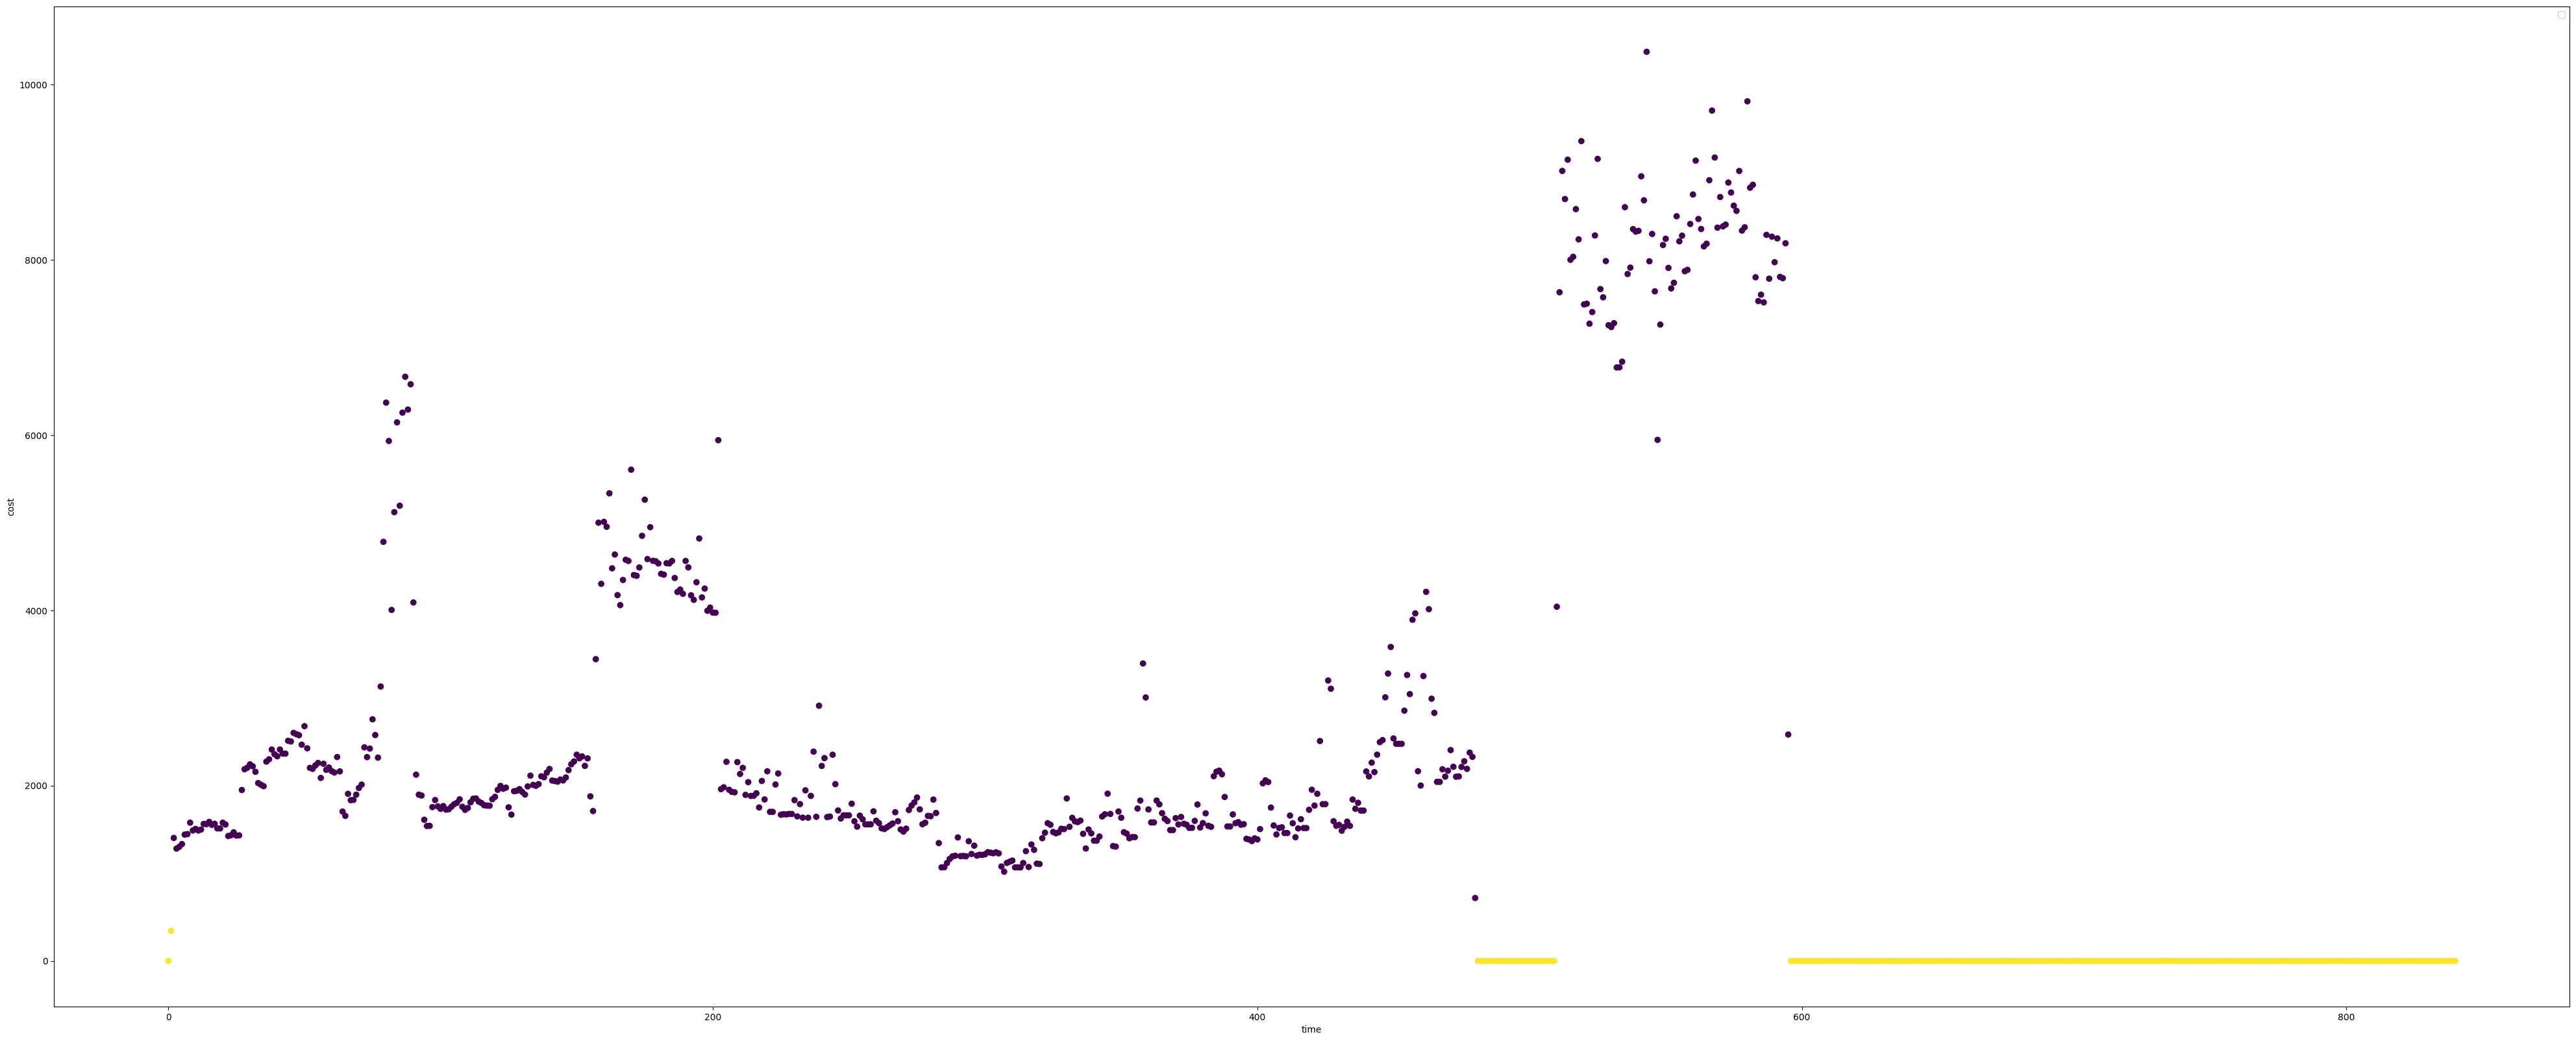

In [6]:
cluster = AgglomerativeClustering(n_clusters=2, linkage='single')
y = data.groupby(data['date'])['cost_for_date'].sum().sort_index()
y = y[y.values >= -5]
x = np.arange(0, 1 * (len(y)), 1)

# Create a 2D array with x and y values
data_2d = pd.DataFrame({
    'x': x,
    'y': y.values*100
})

cluster.fit(data_2d)
data_2d
plt.figure(figsize=[50, 20])
plt.scatter(x, data_2d['y'], c=cluster.labels_)
plt.xlabel('time')
plt.ylabel('cost')
plt.legend()
plt.show()

resultFromClustering = pd.DataFrame({
    'date': y.index,
    'has_promotions': cluster.labels_
})

In [7]:
mlflow.log_params({
    "n_clusters": 2,
    "linkage":'single'
})

In [8]:
# resultFromClustering = resultFromClustering.replace({0: 1, 1: 0})
data = data.merge(resultFromClustering, on='date', how='left')
data = data.sort_values(by='date')

In [9]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data = data.drop(columns=['date'])

data = pd.get_dummies(data)

In [10]:
def splitToTrainAndTest(data) :
    cutoff_date = pd.to_datetime('2023-07-20')
    year = cutoff_date.year
    month = cutoff_date.month
    day = cutoff_date.day
    train = data[(data['year'] < year) |
                  ((data['year'] == year) & (data['month'] < month)) |
                  ((data['year'] == year) & (data['month'] == month) & (data['day'] <= day))]
    test = data[(data['year'] > year) |
                  ((data['year'] == year) & (data['month'] > month)) |
                  ((data['year'] == year) & (data['month'] == month) & (data['day'] > day))]
    data_attr_train = train.drop(columns=['cost_for_date'])
    data_target_train = train.get("cost_for_date")
    data_attr_test = test.drop(columns=['cost_for_date'])
    data_target_test = test.get("cost_for_date")
    return data_attr_train, data_attr_test, data_target_train, data_target_test
X_train, X_test, y_train, y_test = splitToTrainAndTest(data)

In [35]:
# weight_column = 'has_promotions'
# weight = 1000  # Has to be changed for each client
# sample_weights = [weight if is_promotion else 1.0 for is_promotion in X_train[weight_column]]


In [64]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [4, 5, 6],
    'reg_lambda': [1, 10, 500],
    'scale_pos_weight': [0.00000001]
}
# mlflow.log_params({
#     "xgboost_params": param_grid
# })
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
model = xgb.XGBRegressor(**best_params)
print(best_params)

{'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 500, 'scale_pos_weight': 1e-08}


In [65]:
# mlflow.log_params({
#     "best_params": best_params
# })

In [66]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [67]:
predicted_train = np.clip(model.predict(X_train), a_min=0, a_max=None)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

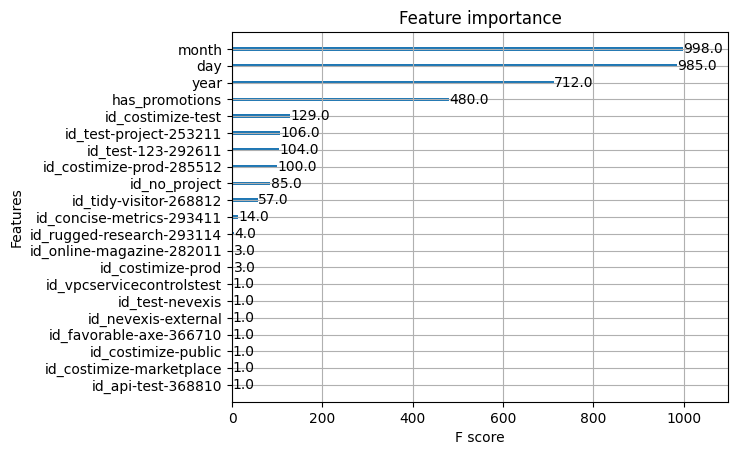

In [68]:
xgb.plot_importance(model)

In [69]:
def concatenate_columns(row):
    return f"{row['year']}-{row['month']}-{row['day']}"

In [70]:
dataframeRes = X_train.assign(date=X_train.apply(concatenate_columns, axis=1))
dataframeRes['pred_res'] = predicted_train
dataframeRes['act_train'] = y_train

In [71]:
daily_costs_pred = dataframeRes.groupby(dataframeRes['date'])['pred_res'].sum()
daily_costs_act = dataframeRes.groupby(dataframeRes['date'])['act_train'].sum()

In [72]:
daily_costs_pred.index = pd.to_datetime(daily_costs_pred.index)
daily_costs_act.index = pd.to_datetime(daily_costs_act.index)

daily_costs_pred = daily_costs_pred.sort_index()
daily_costs_act = daily_costs_act.sort_index()

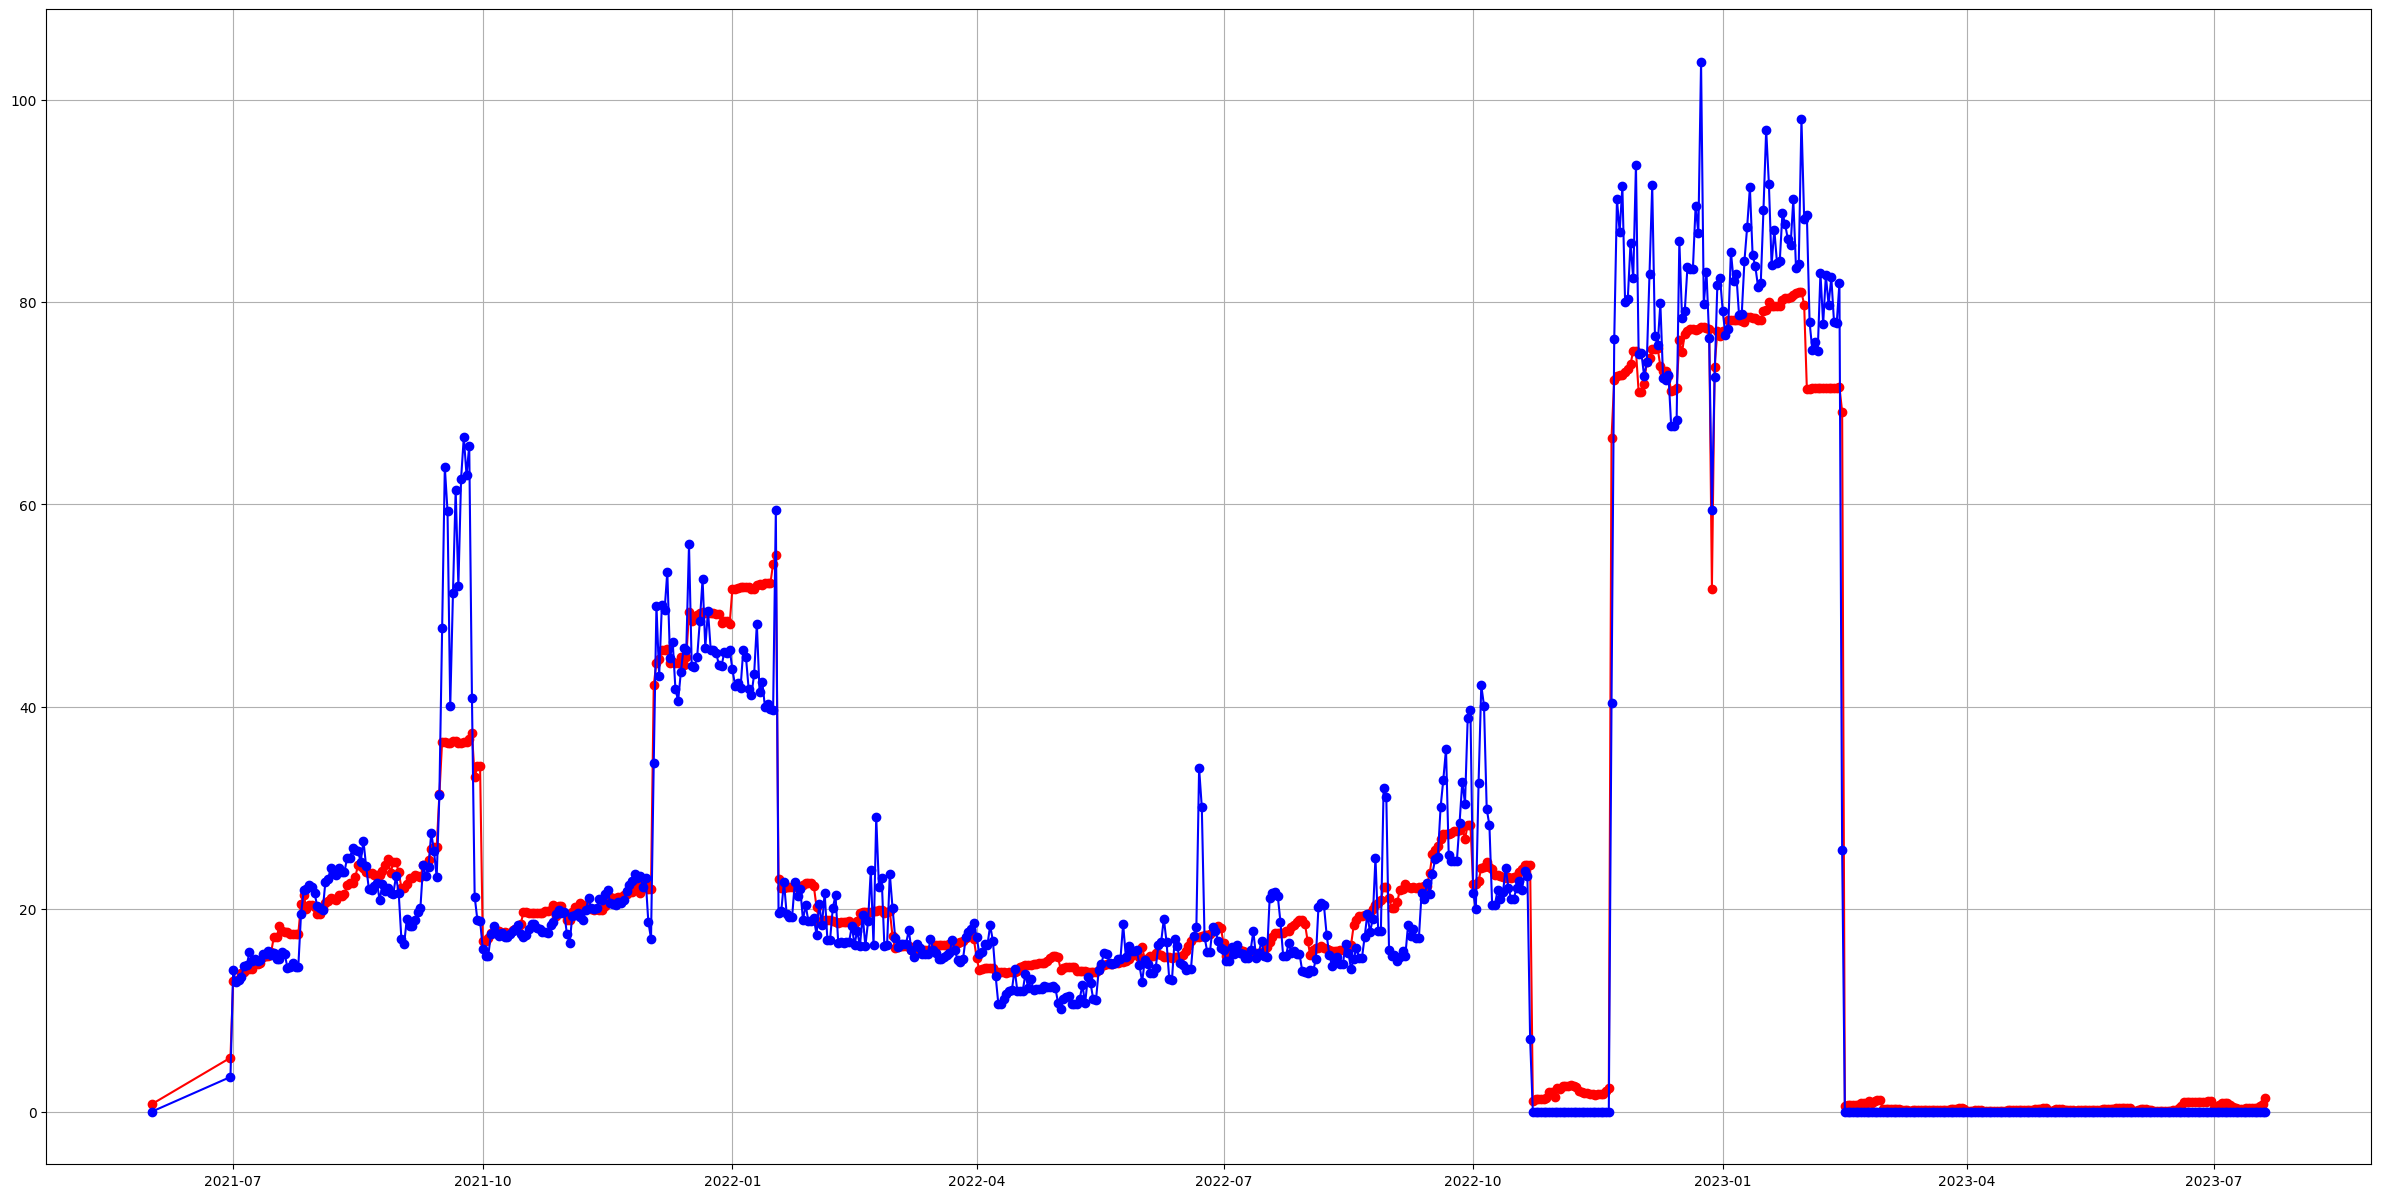

In [73]:
fig, ax = plt.subplots(figsize=(30, 15))

ax.plot(daily_costs_pred.index, daily_costs_pred.values, marker='o', linestyle='-', color='red')
ax.plot(daily_costs_act.index, daily_costs_act.values, marker='o', linestyle='-', color='blue')

plt.grid(True)
plt.show()

In [74]:
predicted_test = np.clip(model.predict(X_test), a_min=0, a_max=None)

In [75]:
dataframeResTest = X_test.assign(date=X_test.apply(concatenate_columns, axis=1))
dataframeResTest['pred_res'] = predicted_test
dataframeResTest['act_train'] = y_test
daily_costs_pred_test = dataframeResTest.groupby(dataframeResTest['date'])['pred_res'].sum()
daily_costs_act_test = dataframeResTest.groupby(dataframeResTest['date'])['act_train'].sum()

In [76]:
daily_costs_pred_test.index = pd.to_datetime(daily_costs_pred_test.index)
daily_costs_act_test.index = pd.to_datetime(daily_costs_act_test.index)

daily_costs_pred_test = daily_costs_pred_test.sort_index()
daily_costs_act_test = daily_costs_act_test.sort_index()

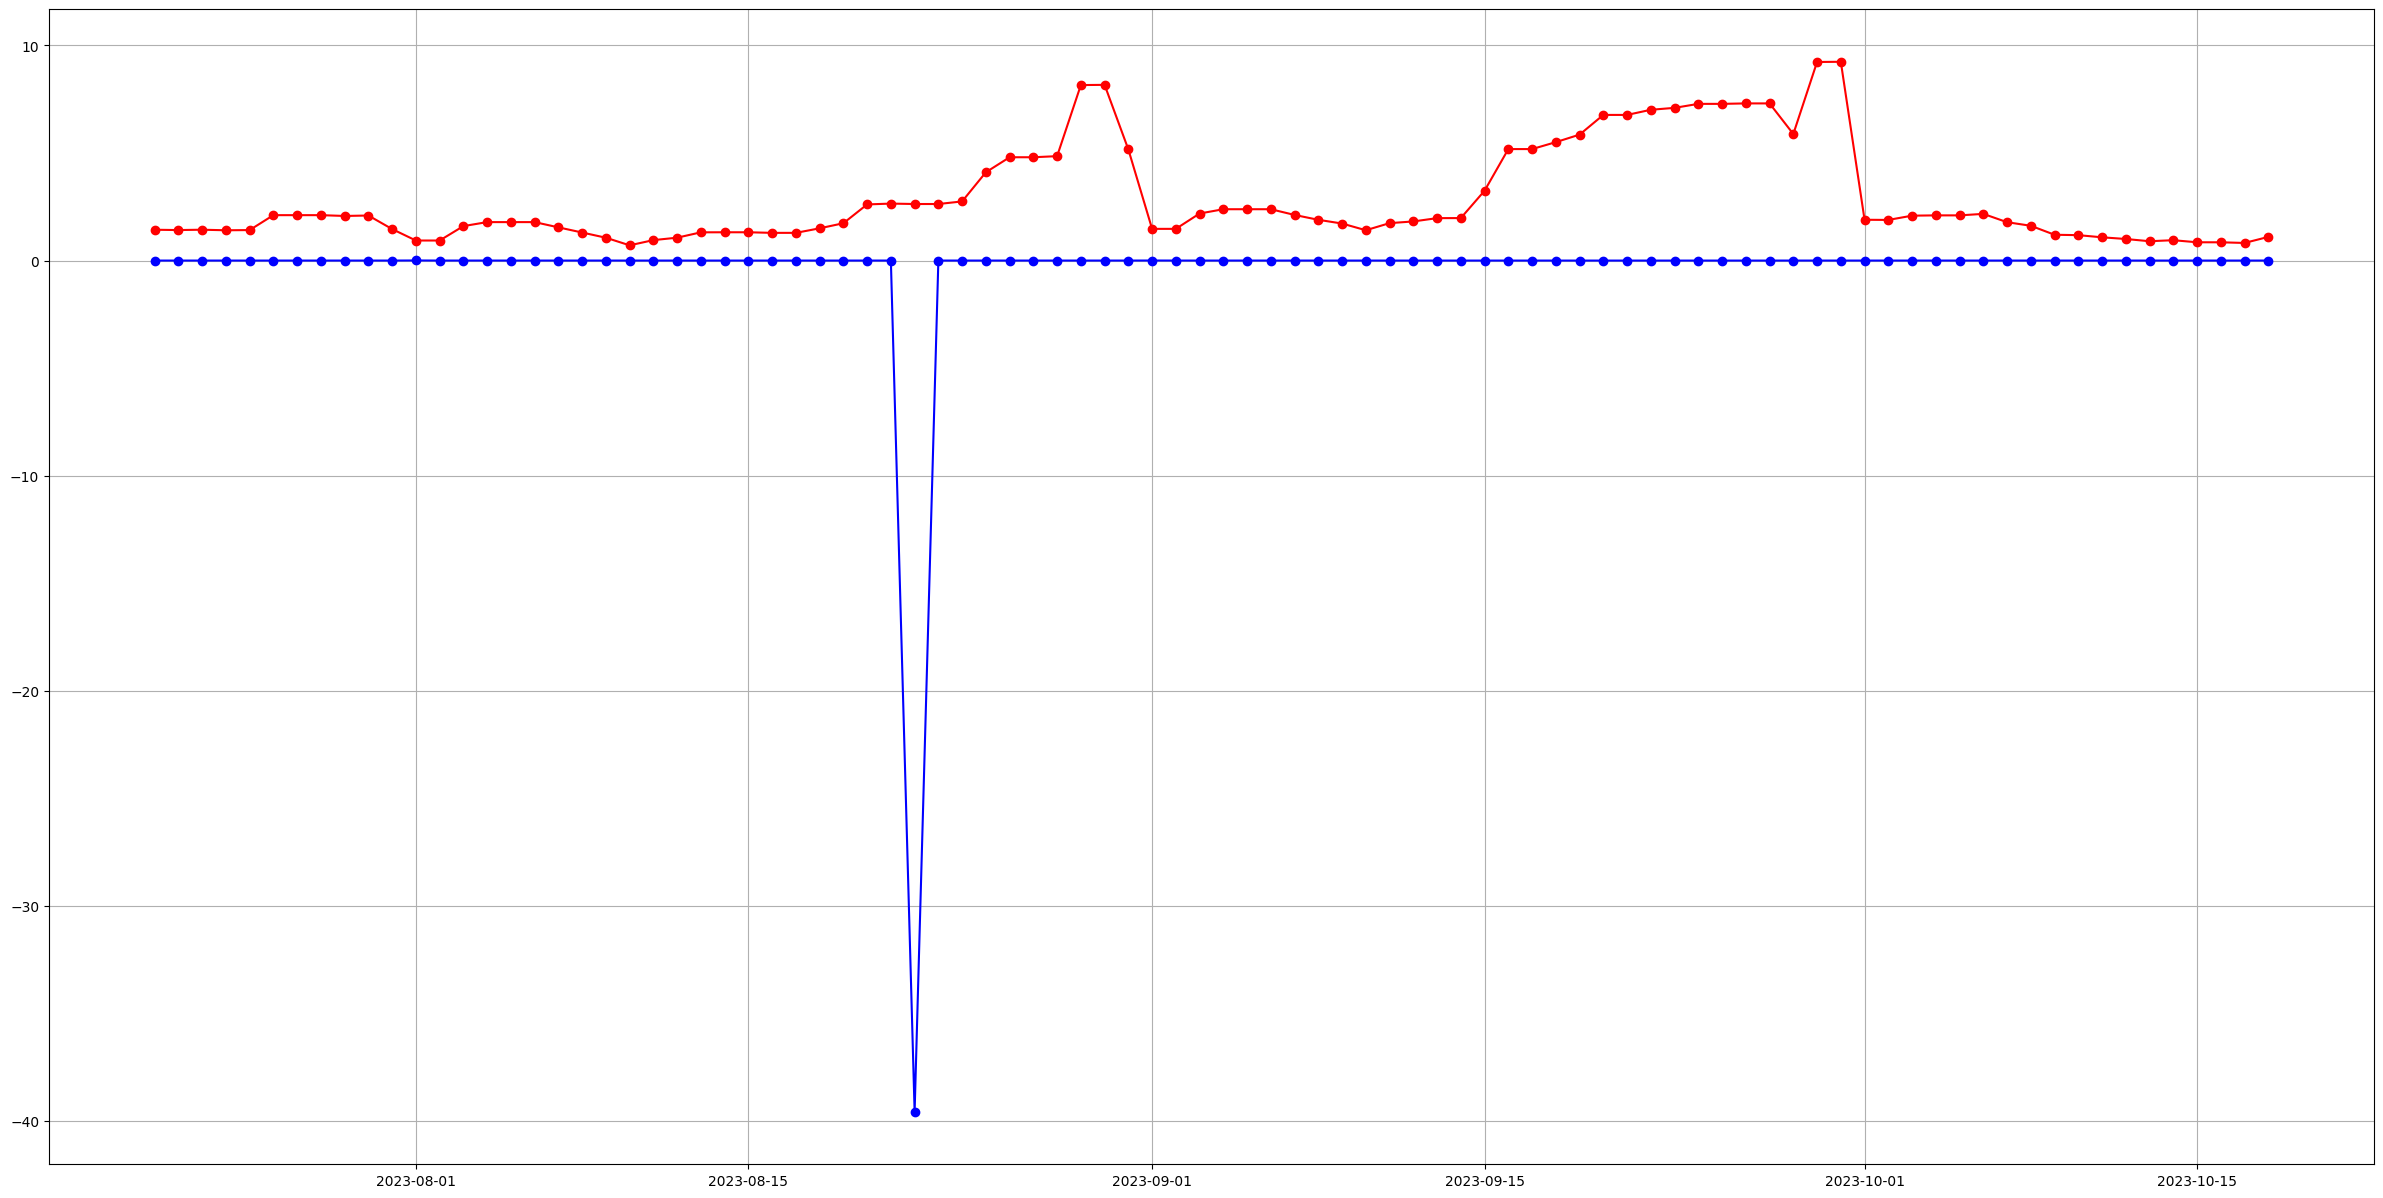

In [77]:
fig, ax = plt.subplots(figsize=(30, 15))

ax.plot(daily_costs_pred_test.index, daily_costs_pred_test.values, marker='o', linestyle='-', color='red')
ax.plot(daily_costs_act_test.index, daily_costs_act_test.values, marker='o', linestyle='-', color='blue')

plt.grid(True)
plt.show()

In [26]:
mlflow.end_run()